In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime as dt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [4]:
pd.set_option('display.max_columns', None)

#Success Map report for IC/MMX status change
df = pd.read_excel('SM_NewManager2023.xlsx', parse_dates=True, skiprows=2)
df.drop(df.columns[[5,7,10,11,12,17,19,21,23]],axis=1,inplace=True)
df['Effective Start Date'] = pd.to_datetime(df['Effective Start Date'], format='%Y-%m-%d')

# Employee Audit for T-level & demographics as they are missing in SM report
ad = pd.read_excel('EEAduit2023.xlsx')

# EIC NLI report for NLI tickets
ec = pd.read_excel('EIC_NLI Jan-Aug2023.xlsx', parse_dates=True)
ec['date'] = ec['Creation'].str[:10]
ec['date'] = pd.to_datetime(ec['date'])
ec.drop_duplicates(subset=['Respective EE'],keep='first', inplace=True) #Keeping only unique NLI tickets for a manager

#BWP report for the IC/MMX status change
#note: BWP already excludes ETs/non-relevant CCs
bw=pd.read_excel('BWP2023.xlsx',skiprows=12,skipfooter=41)

#New Hire report for identifying new external managers for NLI

#### Cleaning SM 2023 report- removing execustives/non-relevant CCs

In [5]:
sm = pd.merge(df,ad,on='User ID',how='left',indicator=True)
sm.drop(['User System ID','Employee Name_y','_merge'],axis=1, inplace=True)
sm.drop(sm[sm['Job Level ID'].isin(['ET','SET','GET'])].index, axis=0,inplace= True)
sm.drop(sm[sm['Company Code'].isin([251,405])].index, axis=0,inplace= True)
sm.sort_values(['Effective Start Date'],inplace=True)

#For each personal ID taking the first & last status change in 2023.
mm = sm.groupby('User ID', as_index=False).agg({'Pers. Number':'last','Employee Name_x':'last','Region':'last','Sub Region':'last','Country':'last','Company Code':'last','Company Name':'last','Prev Employee Type ID':'first','Employee Type ID':'last','Effective Start Date':'last'})

sm_newmanager2023 = mm[(mm['Prev Employee Type ID']=='IC') & ((mm['Employee Type ID']=='MMT') |(mm['Employee Type ID']=='MMM')) ]

#### Cleaning BW 2023 report- formatting of the data

In [6]:
# Removing rows with no status change in 2023. Only duplicated rows have the status change
bw = bw[bw['User ID'].duplicated(keep=False)]
def find_month(arr):
    arr = [0 if pd.isna(x) else x for x in arr]
    i=1
    sum1=0
    last_index=0
    try:
        last_index = len(arr) - arr[::-1].index(1) - 1
    except ValueError:
        last_index = -1 
    
    
    while (i != last_index) & (last_index != -1):
        sum1=sum1+arr[i]
        i += 1
    if (last_index == -1):
        sum1=0
    return pd.Series([last_index,sum1], index=['active_month', 'sum']) 

bw[['active_month', 'sum']]= bw.iloc[:,2:].apply(find_month,axis=1)

In [7]:
def fun(data):
    min_month_index = data['active_month'].idxmin()
    max_month_index = data['active_month'].idxmax()

    return pd.Series({
        "Previous EE Type": data.loc[min_month_index, 'Manager Type | Posting Period'],
        "Employee Type": data.loc[max_month_index, 'Manager Type | Posting Period'],
        'active_month': data.loc[min_month_index, 'active_month'] + 1,
        'Sum': data.loc[max_month_index, 'sum']
    })

results=bw.groupby(['User ID', 'Employee']).apply(fun).reset_index()

In [8]:
bw_newmanager2023= results[(results['Previous EE Type'] =='non-managerial') & ((results['Employee Type']=='MMT')| (results['Employee Type']=='MMM'))]

### Comparing SM report, BW report with EIC NLI tickets in 2023

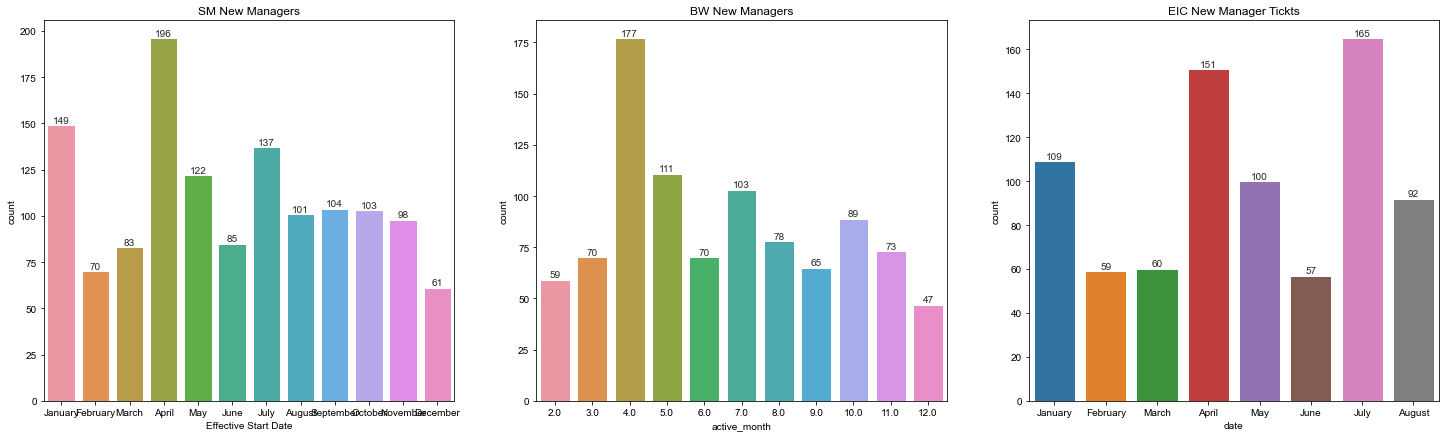

In [9]:
# count of new managers for each month
fig, axs = plt.subplots(ncols=3, figsize=(25,7))
sns.set_style('darkgrid')

from calendar import month_name
month_lookup = list(month_name)

sns.countplot(sm_newmanager2023['Effective Start Date'].dt.month_name(),ax=axs[0], order = sorted(sm_newmanager2023['Effective Start Date'].dt.month_name().unique(), key=month_lookup.index))
sns.countplot(ec['date'].dt.month_name(),ax=axs[2])
sns.countplot(bw_newmanager2023['active_month'],ax=axs[1])

axs[0].set_title("SM New Managers")
axs[2].set_title("EIC New Manager Tickts")
axs[1].set_title("BW New Managers")
for i,row in enumerate(axs):
    for bar in axs[i].patches:
        axs[i].annotate(bar.get_height(),
                (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                size=10, xytext=(0, 5),
                textcoords='offset points')
plt.show()

Key Insights:
1.We see higher increases in new manager assignment in Jan, April, July as the peek months
2.SM & BW data follows the same trend month on month, however, EIC differs slightly. April is the month with highest new managers but highest tickets are recorded in July in EIC.We clearly see missed tickets or some lag in the NLI tickets to the subsequent month. 

### For a particular month, what is the overlap between these reports. 

### New Managers data pipeline using SM report: 
Step1: Building a list of managers for NLI by comparing it in the last 6 months data for taking only the real/latest change in status in SM. SM data is based on the employee type change ( IC/MMT/MMM). In some cases, they are not new managers but when they move to a new position , which may involve EE type change, it will classify them as new manager. Hence we see the SM has higher numbers compared to BW because of False positives. These can be mitigated by comparing the change in the previous 6 months for a dummy change. 

If there are multiple records in SM for one manager then for all records, 
1. if first previous EE type ID is MMT -> last EE type ID is IC [Ignore]
2. if first previous EE type ID is MMT -> last EE type ID is MMT [Ignore]
3. if first previous EE type ID is MMT -> last EE type ID is MMM [Add to new MMM list]
4. if first previous EE type ID is IC -> last EE type ID is MMT [Add to new MMT list]
5. if first previous EE type ID is IC -> last EE type ID is MMM [Add to new MMM list]
6. if first previous EE type ID is IC -> last EE type ID is IC [Ignore]
7. if first previous EE type ID is MMM -> last EE type ID is MMT [Ignore]
8. if first previous EE type ID is MMM -> last EE type ID is MMM [Ignore]

##Note: Missing HR data in SM 

Step 2: Looking at the overlap between SM new managers, BW & NLI tickets in EIC using Pers. Number. 

#### Building SM list for June 2023

In [14]:
# Taking 6 months data from Jan-June month's data
sm_Jan_June = df[df['Effective Start Date'].dt.month.isin([1,2,3,4,5,6])].sort_values('Effective Start Date')

sm_Jan_June = pd.merge(sm_Jan_June,ad,on='User ID',how='left',indicator=True)
sm_Jan_June.drop(['User System ID','Employee Name_y','_merge'],axis=1, inplace=True)
sm_Jan_June.drop(sm_Jan_June[sm_Jan_June['Job Level ID'].isin(['ET','SET','GET'])].index, axis=0,inplace= True)
sm_Jan_June.drop(sm_Jan_June[sm_Jan_June['Company Code'].isin([251,405])].index, axis=0,inplace= True)
sm_Jan_June.sort_values(['Effective Start Date'],inplace=True)

#For each personal ID taking the first & last status change in Jan-June. 
#This logic identifies if a new manager was a manager in the last 6 months.Jan:MMT-IC ; June: IC-MMT/MMM -> MMT-MMT/MMM
# Now, say, IC-MMT & MMT-MMM,--> IC-MMM then it would be a new manager.very few cases in 6 month

mm = sm_Jan_June.groupby('User ID', as_index=False).agg({'Pers. Number':'last','Employee Name_x':'last','Region':'last','Sub Region':'last','Country':'last','Company Code':'last','Company Name':'last','Prev Employee Type ID':'first','Employee Type ID':'last','Effective Start Date':'last'})

sm_June= mm[mm['Effective Start Date'].dt.month==6]

#List of new managers in June in SM report
sm_newmanager_June = sm_June[(sm_June['Prev Employee Type ID']=='IC') & ((sm_June['Employee Type ID']=='MMT') |(sm_June['Employee Type ID']=='MMM')) ]

#### Building BW list for June 2023

In [15]:
bw_Jan_June=pd.read_excel('BWP_Jan_June23.xlsx', skiprows=12,skipfooter=41)

In [16]:
bw_Jan_June = bw_Jan_June[bw_Jan_June['User ID'].duplicated(keep=False)]
bw_Jan_June[['active_month', 'sum']]= bw_Jan_June.iloc[:,2:].apply(find_month,axis=1)
bw_June_results=bw_Jan_June.groupby(['User ID', 'Employee']).apply(fun).reset_index()
bw_June_results= bw_June_results[(bw_June_results['Previous EE Type'] =='non-managerial') & ((bw_June_results['Employee Type']=='MMT')| (bw_June_results['Employee Type']=='MMM'))]
bw_newmanager_June= bw_June_results[(bw_June_results['active_month']==6) & (bw_June_results['Sum']==0)]

#### Building EIC list for June 2023

In [17]:
#List of new managers in June in EIC report
ec_June = ec[ec['date'].dt.month ==6]

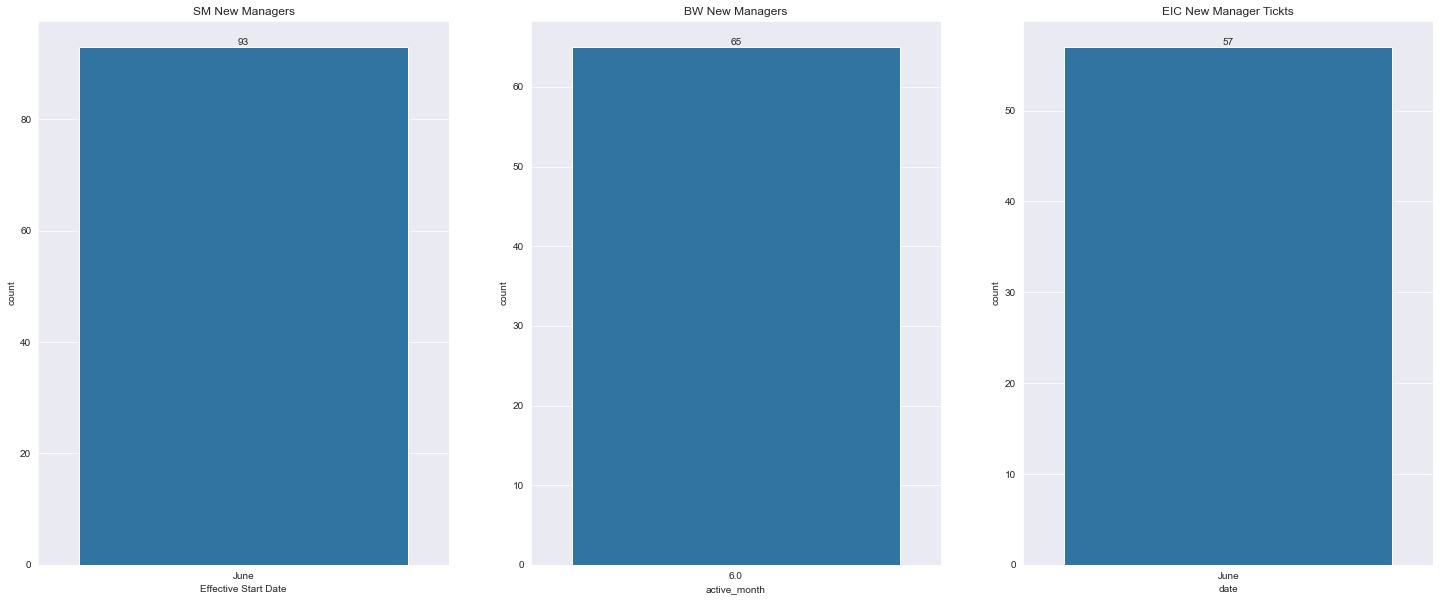

In [18]:
# count of new managers for each month
fig, axs = plt.subplots(ncols=3, figsize=(25,10))
sns.set_style('darkgrid')

from calendar import month_name
month_lookup = list(month_name)

sns.countplot(sm_newmanager_June['Effective Start Date'].dt.month_name(),ax=axs[0], order = sorted(sm_newmanager_June['Effective Start Date'].dt.month_name().unique(), key=month_lookup.index))
sns.countplot(ec_June['date'].dt.month_name(),ax=axs[2])
sns.countplot(bw_newmanager_June['active_month'],ax=axs[1])

axs[0].set_title("SM New Managers")
axs[2].set_title("EIC New Manager Tickts")
axs[1].set_title("BW New Managers")
for i,row in enumerate(axs):
    for bar in axs[i].patches:
        axs[i].annotate(bar.get_height(),
                (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                size=10, xytext=(0, 5),
                textcoords='offset points')
plt.show()

### How many new managers in SM have an equivalent ticket in June in EIC?

In [19]:
sm_newmanager_June['NLI Flag'] = sm_newmanager_June['Pers. Number'].isin(ec_June['Respective EE']).apply(lambda x : 1 if x else 0)
sm_newmanager_June['NLI Flag'].value_counts()

NLI Flag
0    51
1    42
Name: count, dtype: int64

In [105]:
sm_newmanager_June['NLI Flag'].value_counts()/len(sm_newmanager_June['NLI Flag'])

0    0.548387
1    0.451613
Name: NLI Flag, dtype: float64

### How many new managers in BW have an equivalent ticket in June in EIC?

In [20]:
bw_newmanager_June = pd.merge(bw_newmanager_June,ad,on='User ID',how='left',indicator=True)

In [21]:
bw_newmanager_June['NLI Flag'] = bw_newmanager_June['Personnel Number'].isin(ec_June['Respective EE']).apply(lambda x : 1 if x else 0)
bw_newmanager_June['NLI Flag'].value_counts()

NLI Flag
1    49
0    16
Name: count, dtype: int64

In [22]:
bw_newmanager_June['NLI Flag'].value_counts()/ len(bw_newmanager_June['NLI Flag'])

NLI Flag
1    0.753846
0    0.246154
Name: count, dtype: float64

In [ ]:
bw_newmanager_June[(bw_newmanager_June['NLI Flag']==0)]

### How many new managers in SM are also identified as a new manager in BW in June?

In [24]:
sm_newmanager_June['BW Flag'] = sm_newmanager_June['User ID'].isin(bw_newmanager_June['User ID']).apply(lambda x : 1 if x else 0)

In [25]:
sm_newmanager_June['BW Flag'].value_counts()

BW Flag
1    50
0    43
Name: count, dtype: int64

In [26]:
sm_newmanager_June[['NLI Flag','BW Flag']].value_counts()

NLI Flag  BW Flag
0         0          41
1         1          40
0         1          10
1         0           2
Name: count, dtype: int64

In [ ]:
sm_newmanager_June[(sm_newmanager_June['NLI Flag']==0) & (sm_newmanager_June['BW Flag']==0)]

#### Cases where NLI ticket was created correctly in June but missing in SM report ( These should be in SM report as per the org chart) - True negative in SM

In [275]:
ec_June['SM Flag'] = ec_June['Respective EE'].isin(mm['Pers. Number']).apply(lambda x : 1 if x else 0)
ec_June[ec_June['SM Flag'] == 0]